In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

In [26]:
PATH = 'dropout/config_1/'

In [23]:
# Load the results
accuracy_scores = np.load(PATH + 'accuracy_scores.npy')
precision_scores = np.load(PATH + 'precision_scores.npy')
recall_scores = np.load(PATH + 'recall_scores.npy')
f1_scores = np.load(PATH + 'f1_scores.npy')

# Losses
e_train_losses = np.load(PATH + 'e_train_losses.npy')
e_test_losses = np.load(PATH + 'e_test_losses.npy')
b_train_losses = np.load(PATH + 'b_train_losses.npy')
b_test_losses = np.load(PATH + 'b_test_losses.npy')
lr_scores = np.load(PATH + 'lr_scores.npy')



# get the shape of all
print(f"Accuracy scores shape: {accuracy_scores.shape}")
print(f"Precision scores shape: {precision_scores.shape}")
print(f"Recall scores shape: {recall_scores.shape}")
print(f"F1 scores shape: {f1_scores.shape}")
print(f"E train losses shape: {e_train_losses.shape}")
print(f"E test losses shape: {e_test_losses.shape}")
print(f"B train losses shape: {b_train_losses.shape}")

Accuracy scores shape: (0,)
Precision scores shape: (0,)
Recall scores shape: (0,)
F1 scores shape: (0,)
E train losses shape: (75,)
E test losses shape: (75,)
B train losses shape: (353475,)


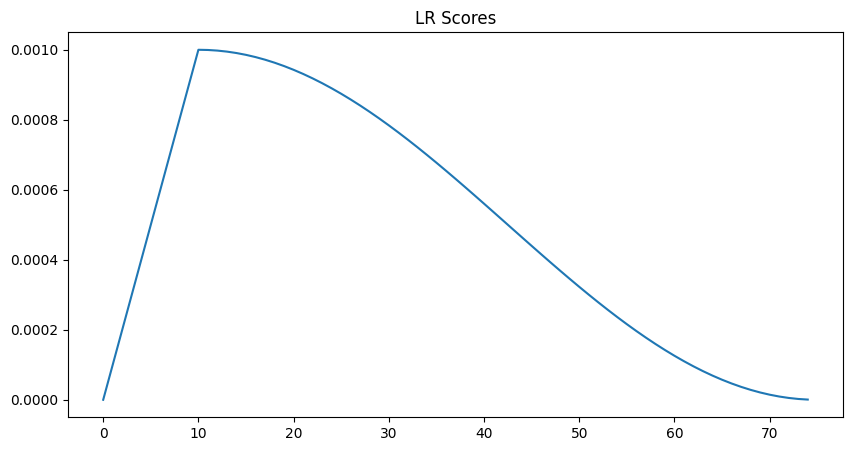

In [28]:
# Plot the LR Scores
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x=range(len(lr_scores)), y=lr_scores, ax=ax)
plt.title('LR Scores')
plt.show()


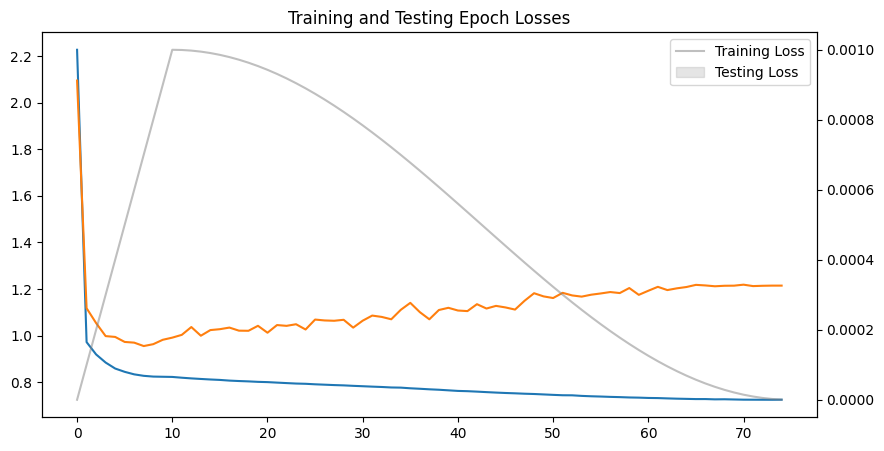

In [29]:
# Plot the Losses
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x=range(len(e_train_losses)), y=e_train_losses, ax=ax)
sns.lineplot(x=range(len(e_test_losses)), y=e_test_losses, ax=ax)
ax2 = ax.twinx()
# create a faded line
sns.lineplot(x=range(len(lr_scores)), y=lr_scores, ax=ax2, color='gray', alpha=0.5)
plt.title('Training and Testing Epoch Losses')
plt.legend(['Training Loss', 'Testing Loss'])
plt.show()


In [26]:
# Import the Model .pth file for evaluation metrics
from capture24.patch_tst import PatchTST
import yaml

# load the config file
with open('capture24/configs/config_4.yaml', 'r') as f:
    config = yaml.safe_load(f)

config['num_batches'] = 128
model = PatchTST(config)
model.load_state_dict(torch.load(f'{PATH}/patchtst_model.pth', weights_only=True, map_location=torch.device('mps')))
model.eval()
print(model)
print(f"Model loaded")


PatchTST(
  (inst_norm): InstanceNorm1d(3, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (patching_layer): PatchingLayer()
  (flatten1): Flatten(start_dim=0, end_dim=1)
  (linear1): Linear(in_features=16, out_features=128, bias=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (flatten2): Flatten(start_dim=1, end_

In [27]:
import gzip
from capture24.patch_tst import C24_Dataset
from torch.utils.data import DataLoader
import json
# Run Single Evaluation  on the Test Set
with gzip.open('capture24/final_data_1024_mode//X_test.npy.gz', 'rb') as f:
    X_test = np.load(f)

with gzip.open('capture24/final_data_1024_mode/Y_test.npy.gz', 'rb') as f:
    Y_test = np.load(f)

# Load the index to label and label to index
with open('capture24/final_data_1024_mode/label_to_index.json', 'r') as f:
    data = json.load(f)

idx_to_label = data['index_to_label']
label_to_idx = data['label_to_index']

# INsert into loader
test_dataset = C24_Dataset(X_test, Y_test, idx_to_label, label_to_idx)
test_loader = DataLoader(
    test_dataset, 
    batch_size=128, 
    shuffle=False, 
    num_workers=0, 
    pin_memory=False, 
    drop_last=True, 
    persistent_workers=False, 
    prefetch_factor=None,
)

KeyboardInterrupt: 

In [ ]:
from torchmetrics.classification import MulticlassF1Score, ConfusionMatrix, CohenKappa, MulticlassMatthewsCorrCoef
from torch.utils.data import Subset
import tqdm
f1_score = MulticlassF1Score(num_classes=10, average='macro')
f1_score_micro = MulticlassF1Score(num_classes=10, average='micro')
f1_score_none = MulticlassF1Score(num_classes=10, average=None)
cm = ConfusionMatrix(num_classes=10, task='multiclass')
ck = CohenKappa(task = 'multiclass', num_classes=10)
mcc = MulticlassMatthewsCorrCoef(num_classes=10)


# Need to utilize bootstrapping to get the confidence intervals - n = 100 per the paper Capture24
# select total length N of test set

N = len(Y_test)

for x, y in test_loader:
    outputs = model(x)

    preds = outputs.argmax(dim=1)


    f1_score.update(preds, y)
    f1_score_micro.update(preds, y)
    f1_score_none.update(preds, y)
    cm.update(preds, y)
    ck.update(preds, y)
    mcc.update(preds, y)
    

# Evaluation Metrics - append to the lists
print(f"F1 score {f1_score.compute()}")
print(f"f1_score micro: {f1_score_micro.compute()}")
print(f"F1-score None: {f1_score_none.compute()}")
print(f"CK Score: {ck.compute()}")
print(f"MCC Score: {mcc.compute()}")

# Reset the metrics
f1_score.reset()
f1_score_micro.reset()
f1_score_none.reset()
ck.reset()
mcc.reset()

# Confusion Matrix
cm.compute()


F1 score 0.442226380109787
f1_score micro: 0.7135967016220093
F1-score None: tensor([0.7173, 0.4161, 0.0740, 0.2375, 0.7647, 0.9208, 0.1842, 0.0998, 0.6489,
        0.3589])
CK Score: 0.6048864126205444
MCC Score: 0.6062272191047668


tensor([[  1781,     76,     31,     43,    122,      3,     11,      5,    246,
            114],
        [    26,   9475,    737,    710,   7317,    182,    132,    391,    836,
           3523],
        [    84,   1664,    282,    140,    916,     37,     37,     59,    792,
            964],
        [   150,   2292,    354,   2937,   4073,    150,     68,    449,    790,
           5118],
        [    32,   3019,    381,   1035,  79646,  10073,    104,   1237,   1356,
           1954],
        [     1,    143,     23,     74,   5701, 101344,      7,    107,     92,
            152],
        [   144,    469,    150,    138,    380,     38,    317,     63,     85,
            734],
        [    29,    913,    108,    424,   5310,    289,     42,    628,    374,
            919],
        [   178,    306,     77,    173,   1582,     81,     72,    130,   7729,
            316],
        [   109,   3855,    507,   2675,   4414,    270,    133,    479,    878,
           7588]])

(<Figure size 1500x1500 with 1 Axes>,
 <Axes: xlabel='Predicted class', ylabel='True class'>)

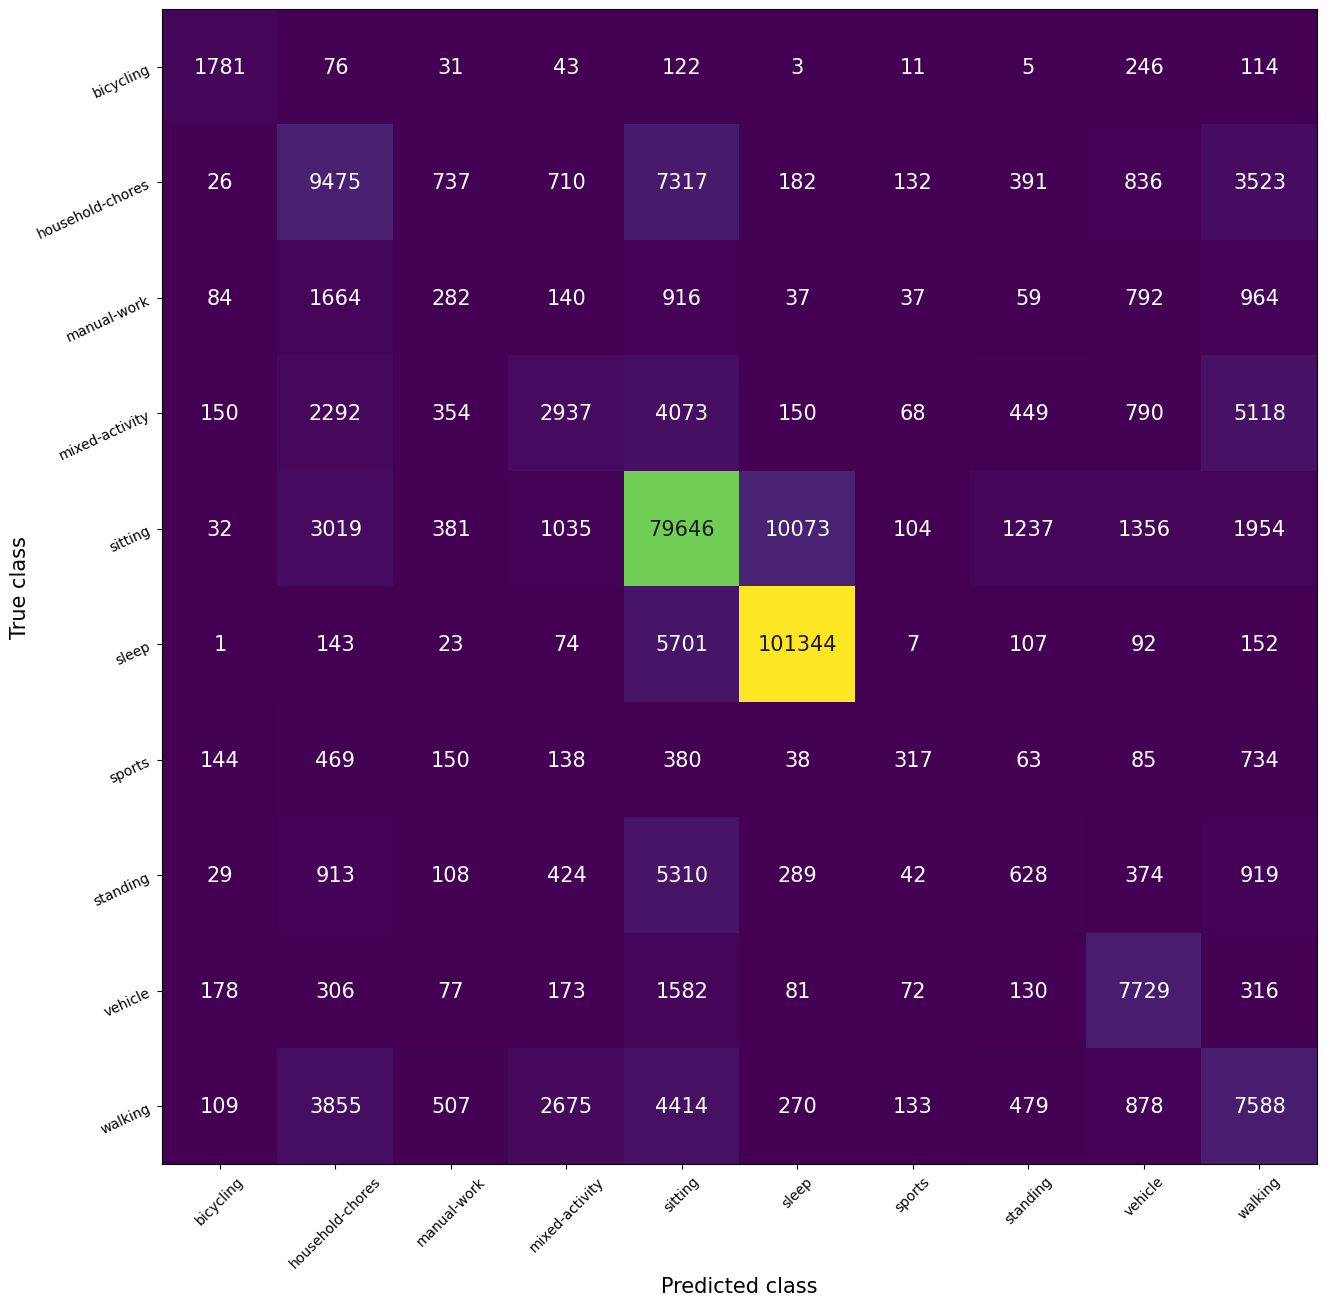

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
cm.plot(ax=ax, labels=idx_to_label.values())

In [ ]:
# Create a bar ploy showing the main miscalssification errors